# The microprice

An estimator of the fair price, given the state of the order book

KISS

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2970694

# Big question:

What is the fair price, given the bid/ask prices and sizes?

We will call this notion of fair price the microprice.

This notion can be useful to algorithmic traders, HFT, market makers, etc...

# Definitions

The bid, ask, bid size, ask size: $P^b, P^a, Q^b, Q^a$

The mid-price: $$M=\frac{P^b+P^a}{2}$$

The weighted mid-price: $$M=P^b (1-I) +P^a I$$

The imbalance: $$I=\frac{Q_b}{Q_b+Q_a}$$

The bid-ask spread: $$S=(P^a-P^b)$$

In [6]:
import pandas as pd
import numpy as np
%matplotlib inline

In [7]:
yfii_test1 = ["yfii_test1.csv","yfii_test2.csv","yfii_orderbook2.csv",10]
yfii_test2 = ["yfii_test2.csv","yfii_test3.csv","yfii_orderbook3.csv",10]
grail_test1 = ["grail_test1.csv","grail_test2.csv","grail_orderbook2.csv",5]
grail_test2 = ["grail_test2.csv","grail_test3.csv","grail_orderbook3.csv",5]

In [8]:
current_test = yfii_test1

In [9]:
def get_df(filename):
    # file1='%s_20110301_20110331.csv'%str(ticker)
    file1 = filename
    df=pd.read_csv(file1)
    del df[df.columns[0]]
    df.columns = ['date','time','bid','bs','ask','as']
    df = df.dropna()
    df['date']=df['date'].astype(float)
    df['time']=df['time'].astype(float)
    df['bid']=df['bid'].astype(float)
    df['ask']=df['ask'].astype(float)
    df['bs']=df['bs'].astype(float)
    df['as']=df['as'].astype(float)
    df['mid']=(df['bid'].astype(float)+df['ask'].astype(float))/2
    df['imb']=df['bs'].astype(float)/(df['bs'].astype(float)+df['as'].astype(float))
    df['wmid']=df['ask'].astype(float)*df['imb']+df['bid'].astype(float)*(1-df['imb'])
    return df

In [10]:
data=get_df(current_test[0])
data


FileNotFoundError: [Errno 2] No such file or directory: 'yfii_test1.csv'

<Axes: >

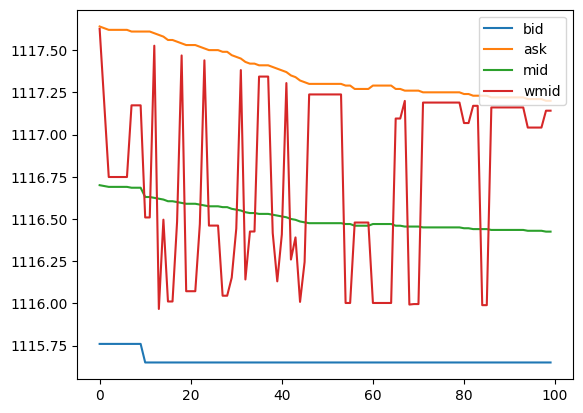

In [2142]:
data[['bid','ask','mid','wmid']].iloc[:100].plot()

# The mid vs. the weighted mid

The mid-price:
- Not a martingale (Bid-ask bounce)
- Medium frequency signal 
- Doesn't use volume at the best bid and ask prices. 

The weighted mid-price:
- Uses the volume at the best bid and ask prices.
- High frequency signal
- Is quite noisy, particularly when the spread widens to two ticks


# Desirable features of the Micro-Price

 $P_t^{micro}=F(M_t,I_t,S_t) = M_t+ G(I_t,S_t)$ 
- Martingale
- Computationally fast
- Better short term price predictions than the midprice or weighted midprice
- Should work for large tick stocks (like BAC) or small tick stocks (like CVX)

# Outline

1. General definition
2. A discrete Markov model
3. Data analysis
4. Conclusion

# Micro-price definition

Define
\begin{equation*}
P_t^{micro}=\lim_{n\to\infty} P_t^n
\end{equation*}
where the approximating sequence of martingale prices is given by
$$P^n_t=\mathbb{E} \left[  M_{\tau_n} |  I_t,S_t \right] $$

$\tau_1,...,\tau_n$ are (random) times when the mid-price $M_t$ changes
 
The micro-price is the expected mid-price in the distant future
 
In practice, the distant future is well captured by $P_t^6$, the expected mid price after 6 price moves.

# Main result


The $i$-th approximation to the micro-price can be written as
\begin{equation*}
P_t^{n} =  M_t + \sum_{k=1}^{n}g^k(I_t,S_t) 
\end{equation*}
where
$$g^1(I_t,S_t)= \mathbb{E}  \left[  M_{\tau_1} - M_t  | I_t, S_t \right] $$
and
$$
g^{n+1}(I_t,S_t)= \mathbb{E}\left[ g^n(I_{\tau_{1}},S_{\tau_{1}}) | I_{t},S_t\right], \forall j\geq 0
$$
can be computed recursively.

# Finite state Markov chain

- The imbalance takes discrete values $1\leq i_I \leq n$, 
- The spread takes discrete values $1\leq i_S \leq m$
- The mid-price changes takes values in $K =[-0.01 \quad -0.005 \quad 0.005 \quad 0.01]$. 
- Define the state $X_t=(I_t,S_t)$ with discrete values $1\leq i \leq nm$

# Computing $g^1$

The first step approximation to the micro-price 
\begin{align*}
g^1(i) = &  \mathbb{E} \left[M_{\tau_{1}}- M_{t} | X_t= i \right] \\
= {}& \big(1-Q\big)^{-1}R^1\underline{k}
\end{align*}

Where
$$Q_{ij} := \mathbb{P}(M_{t+1}- M_t =0 \wedge X_{t+1}=j | X_t= i)$$
are the transition probabilities for transient states (mid price does not move) 

$$R^1_{ik} := \mathbb{P}(M_{t+1}- M_t =k | X_t = i)$$ are the transition probabilities into absorbing states (mid price does move) 

and $$\underline{k}=[-0.01 \quad -0.005 \quad 0.005 \quad 0.01]^T$ 

# Computing $g^{i+1}$


We can compute recursively
\begin{align*}
g^{n+1}=  B g^n
\end{align*}
where $B:=\big(1-Q\big)^{-1}R^2$

and $R^2$ is a new matrix of absorbing states
\begin{align*}
R^2_{ik} := {}& \mathbb{P}(M_{t+1}- M_t \neq 0 \wedge I_{t+1}=k  | I_t = i)
\end{align*}

# Does the micro-price converge?

Yes. But we have to appropriately symmetrize the data.

Technical conditions are available in the paper.

# Data analysis on BAC and CVX

# Estimation

1. On every quote, compute $I_t, S_t, (M_{t+1}-M_t)$, after having discretized the state space
2. Symmetrize the data, by making a copy where $I^2_t=n-I_t, S^2_t=S_t, (M^2_{t+1}-M^2_t)=-(M_{t+1}-M_t)$
3. Estimate transition probability matrices $Q, R^1, R^2$


# Computation

Compute the first micro-price adjustment:
$$p^{1}-M = g^1 = \big(1-Q\big)^{-1}R^1\underline{k}$$
Use our recursive formula to compute the 6th micro-price adjustment:
$$p^{6}-M = g^1+g^2+ \ldots +g^6 = g^1 + B g^1 + \ldots + B^5 g^1 $$
In practice this converges after 6 price moves

In [2076]:
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [2077]:
def prep_data_sym(T,n_imb,dt,n_spread):
    spread=T.ask-T.bid
    ticksize=np.round(min(spread.loc[spread>0])*100)/100
    T.spread=T.ask-T.bid
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2
    #filter out spreads >= n_spread
    print(T)
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])
    #discretize imbalance into percentiles
    T['imb_bucket'], bins = pd.qcut(T['imb'], n_imb, labels=False, retbins = True)
    T['next_mid']=T['mid'].shift(-dt)
    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]
    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    return T3,ticksize,bins

In [2078]:
def estimate(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()
    print(no_move_counts)
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']!=0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb*n_spread)]
    R1=T1[:,(n_imb*n_spread):]

    K=np.array([-0.01, -0.005, 0.005, 0.01])
    move_counts=T[(T['dM']!=0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
    
    return G1,B,Q,Q2,R1,R2,K

In [2079]:
def plot_Gstar(ticker,G1,B,T):
    G2=np.dot(B,G1)+G1
    G3=G2+np.dot(np.dot(B,B),G1)
    G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
    G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
    G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1)
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb)*0,label='Mid adj',marker='o')
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb),label='Weighted mid adj',marker='o')
    for i in range(0,n_spread):
        plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick adj",marker='o')
    plt.ylim(-0.25,0.25)
    # plt.legend(loc='upper left')
    plt.title(ticker+' adjustments')
    plt.xlabel('Imbalance')
    plt.legend('',frameon=False)
    return G6

In [2080]:
def market_order(O, side, dollar_value,i):
    side = "ask" if side == "buy" else "bid"
    total_price = 0
    total_qty = 0
    row = O.loc[i]
    for i in range(20):
        if(total_price < dollar_value):
            total_price += float(row[side+"_"+str(i)+"_px"]) * float(row[side+"_"+str(i)+"_qty"])
            total_qty += float(row[side+"_"+str(i)+"_qty"])
            last = i            
                
    if total_price >= dollar_value:
        extra = total_price - dollar_value
        total_qty = total_qty - extra / float(row[side+"_"+str(last)+"_px"])
    else:
        extra = dollar_value - total_price
        total_qty = total_qty + extra / float(row[side+"_"+str(last)+"_px"])

    #         print(total_price)  
    avg_price = dollar_value / total_qty
    market_avg_price = avg_price
    return market_avg_price

# Calculating G6


In [2115]:
n_imb=current_test[3]
n_spread=500
dt=1
data=get_df(current_test[0]) 
ticker='GRAIL-USDT'
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
T,ticksize,bins=prep_data_sym(data,n_imb,dt,n_spread)

ticksize




       date          time      bid      bs      ask      as       mid  \
0       1.0  1.681366e+12  2130.06  0.0514  2136.32  0.0366  2133.190   
1       1.0  1.681366e+12  2130.06  0.0514  2136.31  0.0044  2133.185   
2       1.0  1.681366e+12  2130.06  0.0514  2136.31  0.0095  2133.185   
3       1.0  1.681366e+12  2130.06  0.0514  2136.30  0.0414  2133.180   
4       1.0  1.681366e+12  2130.06  0.0514  2136.29  0.0067  2133.175   
...     ...           ...      ...     ...      ...     ...       ...   
27577   1.0  1.681369e+12  2130.06  0.0537  2145.06  0.0082  2137.560   
27578   1.0  1.681369e+12  2130.06  0.0537  2145.05  0.0776  2137.555   
27579   1.0  1.681369e+12  2130.06  0.0537  2145.05  0.0776  2137.555   
27580   1.0  1.681369e+12  2130.06  0.0537  2145.04  0.0072  2137.550   
27581   1.0  1.681369e+12  2130.06  0.0537  2145.03  0.0776  2137.545   

            imb         wmid  spread  
0      0.584091  2133.716409    5.74  
1      0.921147  2135.817168    5.74  
2     

2.87

In [2116]:
ticksize_test = ticksize

In [2117]:
bins_test = bins

spread  imb_bucket  next_imb_bucket
5.74    0           0.0                 87
                    1.0                126
                    2.0                320
                    3.0                  6
                    4.0                  0
                                      ... 
14.35   4           0.0                578
                    1.0                679
                    2.0                496
                    3.0                221
                    4.0                613
Length: 100, dtype: int64


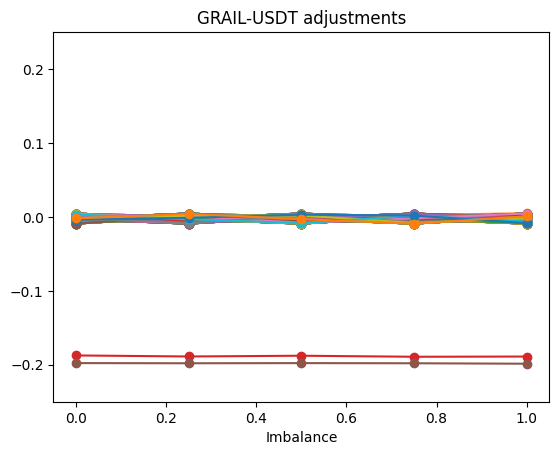

In [2118]:
imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate(T)
G6=plot_Gstar(ticker,G1,B,T)

Text(0.5, 0, 'Imbalance')

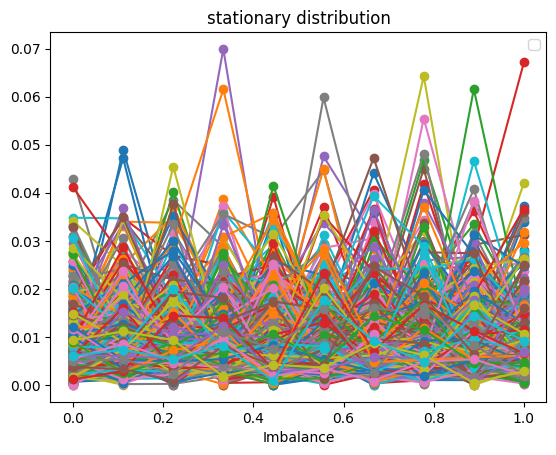

In [2012]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend('', frameon = 'False')
plt.title('stationary distribution')
plt.xlabel('Imbalance')

In [2092]:
def prep_data_sym_test(T,n_imb,dt,n_spread,ticksize):
    spread=T.ask-T.bid
    T.spread=T.ask-T.bid
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2
    #filter out spreads >= n_spread
    print(T)
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])
    #discretize imbalance into percentiles
    T['imb_bucket'], bins = pd.qcut(T['imb'], n_imb, labels=False, retbins = True)
    T['next_mid']=T['mid'].shift(-dt)
    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]
    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    return T3,ticksize,bins

In [2119]:
data=get_df(current_test[1]) 
ticker='GRAIL-USDT'
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
T,ticksize,bins=prep_data_sym_test(data,n_imb,dt,n_spread,ticksize_test)

       date          time      bid      bs      ask      as       mid  \
0       1.0  1.681369e+12  2130.06  0.0537  2145.03  0.1060  2137.545   
1       1.0  1.681369e+12  2130.06  0.0537  2145.03  0.1060  2137.545   
2       1.0  1.681369e+12  2130.06  0.0537  2145.02  0.0057  2137.540   
3       1.0  1.681369e+12  2130.06  0.0537  2145.02  0.0072  2137.540   
4       1.0  1.681369e+12  2130.06  0.0537  2145.02  0.0197  2137.540   
...     ...           ...      ...     ...      ...     ...       ...   
27775   1.0  1.681373e+12  2111.08  0.0029  2146.76  0.0443  2128.920   
27776   1.0  1.681373e+12  2111.08  0.0029  2146.75  0.0044  2128.915   
27777   1.0  1.681373e+12  2111.08  0.0029  2146.75  0.0038  2128.915   
27778   1.0  1.681373e+12  2111.08  0.0029  2146.74  0.0443  2128.910   
27779   1.0  1.681373e+12  2111.08  0.0029  2146.74  0.0443  2128.910   

            imb         wmid  spread  
0      0.336255  2135.093745   14.35  
1      0.336255  2135.093745   14.35  
2     

In [2120]:
T=T.drop_duplicates("time")
T["imb_bucket"] = pd.cut(T.imb, 
                            bins=bins_test, 
                            labels=list(range(0,n_imb)))

T["timestamp"] = T["time"]

In [2121]:
order = pd.read_csv(current_test[2]) #copy 2

In [2122]:
order

,Unnamed: 0,timestamp,market_id,market,symbol,ask_0_px,ask_1_px,ask_2_px,ask_3_px,ask_4_px,...,bid_11_qty,bid_12_qty,bid_13_qty,bid_14_qty,bid_15_qty,bid_16_qty,bid_17_qty,bid_18_qty,bid_19_qty,date
0,0,1.681369e+12,1,GT-GRAIL-USDT-SPOT,GRAIL-USDT,2145.03,2145.04,2145.24,2149.53,2153.83,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
1,1,1.681369e+12,1,GT-GRAIL-USDT-SPOT,GRAIL-USDT,2145.03,2145.04,2145.24,2149.53,2153.83,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
2,2,1.681369e+12,1,GT-GRAIL-USDT-SPOT,GRAIL-USDT,2145.02,2145.03,2145.04,2145.24,2149.53,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
3,3,1.681369e+12,1,GT-GRAIL-USDT-SPOT,GRAIL-USDT,2145.02,2145.03,2145.24,2149.53,2153.83,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
4,4,1.681369e+12,1,GT-GRAIL-USDT-SPOT,GRAIL-USDT,2145.02,2145.03,2145.24,2149.53,2153.83,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27775,27775,1.681373e+12,1,GT-GRAIL-USDT-SPOT,GRAIL-USDT,2146.76,2146.77,2146.84,2149.53,2153.83,...,0.0047,0.0052,0.0036,0.0086,0.0114,0.0017,0.0022,0.0025,0.0113,1
27776,27776,1.681373e+12,1,GT-GRAIL-USDT-SPOT,GRAIL-USDT,2146.75,2146.76,2146.84,2149.53,2153.83,...,0.0047,0.0052,0.0036,0.0086,0.0114,0.0017,0.0022,0.0025,0.0113,1
27777,27777,1.681373e+12,1,GT-GRAIL-USDT-SPOT,GRAIL-USDT,2146.75,2146.76,2146.84,2149.53,2153.83,...,0.0047,0.0052,0.0036,0.0086,0.0114,0.0017,0.0022,0.0025,0.0113,1
27778,27778,1.681373e+12,1,GT-GRAIL-USDT-SPOT,GRAIL-USDT,2146.74,2146.75,2146.84,2149.53,2153.83,...,0.0047,0.0052,0.0036,0.0086,0.0114,0.0017,0.0022,0.0025,0.0113,1


In [2123]:
s1 = pd.merge(T, order, how='inner', on=['timestamp'])

In [2124]:
s1 = s1.dropna()

In [2125]:
T.reset_index(drop=True,inplace=True)
s1.reset_index(drop=True,inplace=True)

In [2126]:
s1

,date_x,time,bid,bs,ask,as,mid,imb,wmid,spread,...,bid_11_qty,bid_12_qty,bid_13_qty,bid_14_qty,bid_15_qty,bid_16_qty,bid_17_qty,bid_18_qty,bid_19_qty,date_y
0,1.0,1.681369e+12,2130.06,0.0537,2145.03,0.1060,2137.545,0.336255,2135.093745,14.35,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
1,1.0,1.681369e+12,2130.06,0.0537,2145.03,0.1060,2137.545,0.336255,2135.093745,14.35,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
2,1.0,1.681369e+12,2130.06,0.0537,2145.02,0.0057,2137.540,0.904040,2143.584444,14.35,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
3,1.0,1.681369e+12,2130.06,0.0537,2145.02,0.0072,2137.540,0.881773,2143.251330,14.35,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
4,1.0,1.681369e+12,2130.06,0.0537,2145.02,0.0197,2137.540,0.731608,2141.004850,14.35,...,0.0086,0.0048,0.0048,0.0114,0.0017,0.0022,0.0025,0.0113,0.0049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23892,1.0,1.681373e+12,2111.08,0.0029,2146.81,0.0082,2128.945,0.261261,2120.414865,34.44,...,0.0047,0.0052,0.0036,0.0086,0.0114,0.0017,0.0022,0.0025,0.0113,1
23893,1.0,1.681373e+12,2111.08,0.0029,2146.79,0.0038,2128.935,0.432836,2126.536567,34.44,...,0.0047,0.0052,0.0036,0.0086,0.0114,0.0017,0.0022,0.0025,0.0113,1
23894,1.0,1.681373e+12,2111.08,0.0029,2146.79,0.0082,2128.935,0.261261,2120.409640,34.44,...,0.0047,0.0052,0.0036,0.0086,0.0114,0.0017,0.0022,0.0025,0.0113,1
23895,1.0,1.681373e+12,2111.08,0.0029,2146.75,0.0044,2128.915,0.397260,2125.250274,34.44,...,0.0047,0.0052,0.0036,0.0086,0.0114,0.0017,0.0022,0.0025,0.0113,1


In [2127]:
# working - range - 0,3000, data - test 1(5) testing data test1(4) train, diff<0.3 , diff<0.9, order =  s1, sell, 30,i
# prev = 30
k = []
d = []
placed_sell = 0
filled_sell = 0
placed_buy = 0
filled_buy = 0
import random
interval = 100
twap = []
ls = []
q_twap = 0
for i in range(0,21000,interval):
    s = int(s1.loc[i,'spread']/ticksize)
    imbb = int(s1.loc[i, "imb_bucket"])
    # print(s,imbb)
    required_g6 = G6[(0+(s-1)*n_imb):(n_imb+(s-1)*n_imb)]
    normal_G6 = [(float(i)-min(required_g6))/(max(required_g6)-min(required_g6)) for i in required_g6]
    diff = normal_G6[imbb]
    # print(normal_G6)
    twap.append(market_order(s1, "sell", 50, i))
    print("twap")
    print(market_order(s1, "sell", 50, i))
    # if(diff<0.3):
    #     k.append(market_order(s1, "sell", 30, i))
    #     print("mp")
    #     print(market_order(s1, "sell", 30, i)) 
    #     # placed_sell+=1
    #     # if(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,'bid']>=0.05):
    #     #     filled_sell+=1
    #     #     ls.append(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,"bid"])
    #     #     k.append(max(T.loc[i+1:i+interval,"bid"].to_list()))
    #     #     print("mp")
    #     #     print(max(T.loc[i+1:i+interval,"bid"].to_list()))
    #     #     d.append(diff)
    #     # else:
    #     #     k.append(market_order(s1, "sell", 5, i+interval))
    #     #     print("mp")
    #     #     print(market_order(s1, "sell", 5, i+interval))   
    # else:
    if(diff>0.5):
        placed_sell+=1
        if(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,'bid']>=0.01):
            filled_sell+=1
            ls.append(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,"bid"])
            k.append(max(T.loc[i+1:i+interval,"bid"].to_list()))
            print("mp")
            print(max(T.loc[i+1:i+interval,"bid"].to_list()))
            d.append(diff)
        else:
            k.append(market_order(s1, "sell", 50, i+interval))
            print("mp")
            print(market_order(s1, "sell", 50, i+interval)) 
    else:
        k.append(market_order(s1, "sell", 50, i))
        print("mp")
        print(market_order(s1, "sell", 50, i)) 
        # k.append(market_order(s1, "sell", 5, i))
        # print("mp")
        # print(market_order(s1, "sell", 5, i)) 
        # placed_buy+=1
        # if(max(T.loc[i+1:i+interval,"ask"].to_list())-T.loc[i,'ask']>=0.1):
        #     filled_buy+=1
        #     k.append(max(T.loc[i+1:i+interval,"ask"].to_list())-T.loc[i,'ask'])
        #     d.append(diff)


twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.07
twap
2130.07
mp
2130.07
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.07
mp
2130.07
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.07
twap
2130.07
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.06
twap
2130.06
mp
2130.07
twap
2130.07
mp
2130.0695001099702
twap
2130.0695001099702
mp
2130.06
twap
2130.06
mp
2130.06
twap
2100.010000000001
mp
2100.010000000001
twap
2100.010000000001
mp
2100.010000000001
twap
2100.010000000001
mp
2100.010000000001
twap
2100.010000000001
mp
2100.010000000001
twap
2100.010000000001
mp
2100.010000000001
twap
2100.010000000001
mp
2100.010000000001
twap
2100.010000000001
mp
2100.010000000001
twap
2100.010000000001
mp
2100.010000000001
tw

In [2128]:
filled_sell/placed_sell

0.28225806451612906

In [2129]:
sum(k)/len(k)

2111.6590167941245

In [2130]:
sum(twap)/len(twap)

2106.005780849934

1187.1795482800549


<function matplotlib.pyplot.show(close=None, block=None)>

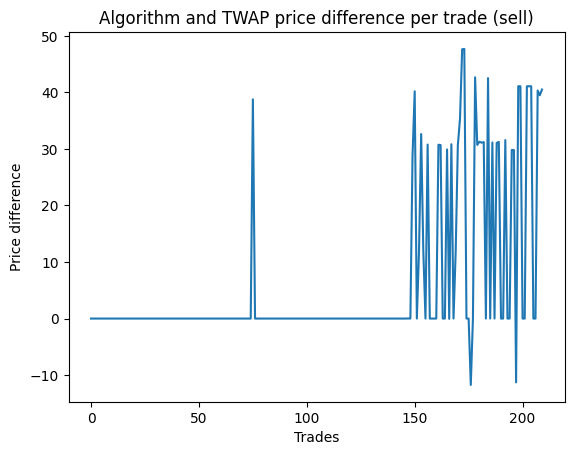

In [2131]:
a = [x1 - x2 for (x1, x2) in zip(k,twap)]
print(sum(a))
plt.plot(list(range(0,210)), a)
# plt.plot(list(range(0,210)), k, '-.')
plt.xlabel("Trades")
plt.ylabel("Price difference")
plt.title("Algorithm and TWAP price difference per trade (sell)")
plt.show

In [2132]:
# working - range - 0,3000, data - test 1(5) testing data test1(4) train, diff<0.3 , diff<0.9, order =  s1, sell, 30,i, interval = 6
k = []
d = []
placed_sell = 0
filled_sell = 0
placed_buy = 0
filled_buy = 0
import random
interval = 100
twap = []
ls = []
q_twap = 0
for i in range(0,21000,interval):
    s = int(s1.loc[i,'spread']/ticksize)
    imbb = int(s1.loc[i, "imb_bucket"])
    # print(s,imbb)
    required_g6 = G6[(0+(s-1)*n_imb):(n_imb+(s-1)*n_imb)]
    normal_G6 = [(float(i)-min(required_g6))/(max(required_g6)-min(required_g6)) for i in required_g6]
    diff = normal_G6[imbb]
    # print(normal_G6)
    twap.append(market_order(s1, "buy", 50, i))
    print("twap")
    print(market_order(s1, "buy", 50, i))
    if(diff<0.5):
        # k.append(market_order(s1, "sell", 30, i))
        # print("mp")
        # print(market_order(s1, "sell", 30, i)) 
        placed_buy+=1
        if(-min(T.loc[i+1:i+interval,"ask"].to_list())+T.loc[i,'ask']>=0.05):
            filled_buy+=1
            ls.append(-min(T.loc[i+1:i+interval,"ask"].to_list())+T.loc[i,"ask"])
            k.append(min(T.loc[i+1:i+interval,"ask"].to_list()))
            print("mp")
            print(min(T.loc[i+1:i+interval,"ask"].to_list()))
            d.append(diff)
        else:
            k.append(market_order(s1, "buy", 50, i+interval))
            print("mp")
            print(market_order(s1, "buy", 50, i+interval))   
    else:
        # if(diff>0.9):
        #     placed_sell+=1
        #     if(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,'bid']>=0.05):
        #         filled_sell+=1
        #         ls.append(max(T.loc[i+1:i+interval,"bid"].to_list())-T.loc[i,"bid"])
        #         k.append(max(T.loc[i+1:i+interval,"bid"].to_list()))
        #         print("mp")
        #         print(max(T.loc[i+1:i+interval,"bid"].to_list()))
        #         d.append(diff)
        #     else:
        #         k.append(market_order(s1, "sell", 30, i+interval))
        #         print("mp")
        #         print(market_order(s1, "sell", 30, i+interval)) 
        # else:
        #     k.append(market_order(s1, "sell", 30, i))
        #     print("mp")
        #     print(market_order(s1, "sell", 30, i)) 
        k.append(market_order(s1, "buy", 50, i))
        print("mp")
        print(market_order(s1, "buy", 50, i)) 
        # placed_buy+=1
        # if(max(T.loc[i+1:i+interval,"ask"].to_list())-T.loc[i,'ask']>=0.1):
        #     filled_buy+=1
        #     k.append(max(T.loc[i+1:i+interval,"ask"].to_list())-T.loc[i,'ask'])
        #     d.append(diff)


twap
2145.03
mp
2145.03
twap
2140.6999999999994
mp
2140.6999999999994
twap
2140.555932943728
mp
2140.555932943728
twap
2140.8959322977294
mp
2140.8959322977294
twap
2144.566911823648
mp
2144.24
twap
2144.356869238971
mp
2143.65
twap
2143.6663557671945
mp
2143.6663557671945
twap
2143.92811334326
mp
2143.58
twap
2143.7500000000005
mp
2143.7500000000005
twap
2143.3799999999997
mp
2143.3799999999997
twap
2143.3481138536604
mp
2143.3481138536604
twap
2143.2700000000004
mp
2143.2700000000004
twap
2143.305241862362
mp
2142.86
twap
2142.867128558047
mp
2142.867128558047
twap
2145.084036666378
mp
2144.65
twap
2144.6581127008612
mp
2144.22
twap
2144.22
mp
2144.22
twap
2144.0700000000006
mp
2144.0700000000006
twap
2143.4900000000002
mp
2143.4900000000002
twap
2143.2552848383734
mp
2143.0
twap
2143.2000000000003
mp
2143.2000000000003
twap
2143.3883710248388
mp
2143.3883710248388
twap
2142.915671310344
mp
2142.915671310344
twap
2143.3099999999995
mp
2143.3099999999995
twap
2144.9299999999994
mp
214

In [2133]:
filled_buy/placed_buy

0.9069767441860465

In [2134]:
sum(k)/len(k)

2149.653436470925

In [2135]:
sum(twap)/len(twap)

2149.850860399294

-41.459024957313886


<function matplotlib.pyplot.show(close=None, block=None)>

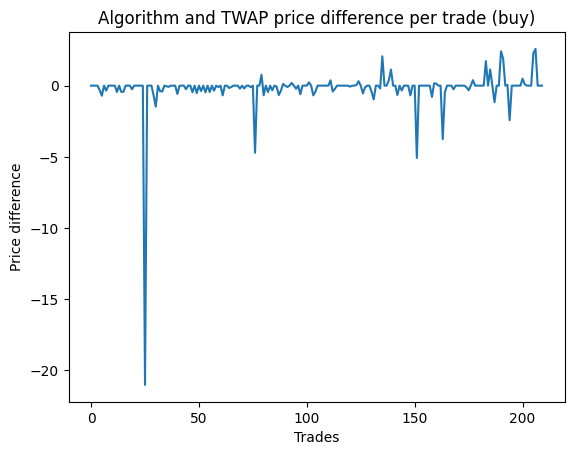

In [2136]:
a = [x1 - x2 for (x1, x2) in zip(k,twap)]
print(sum(a))
plt.plot(list(range(0,210)), a)
# plt.plot(list(range(0,210)), k, '-.')
plt.xlabel("Trades")
plt.ylabel("Price difference")
plt.title("Algorithm and TWAP price difference per trade (buy)")
plt.show



# Summary

1. The micro-price is the expected mid-price in the distant future
2. In practice, the distant future is adequately approximated by $\tau^6$ the time of the 6th mid price move
3. Paper provides evidence that the micro-price is a good predictor of future mid prices
3. Micro-price can fit very different microstructures
4. Micro-price is horizon independent
5. Micro-price seems to live between the bid and the ask